# Container Auto-scaling with Deep Reinforcement Learning

### Policy

in simple terms, policy is the mindset of agent.

the agent sees the current situation (state) and chooses to choose an action. (or multiple actions)
so we define policy as a function of state, that outputs some actions. 

`action = f(state)`

we call the above f function, policy.
 

### Policy gradients method:

Policy gradients are methods that train the policy functions by gradients.  basically in each training, we push the policy to be a bit better. that means taking good actions more frequently and taking bad actions less.

There are many other methods aside from reinforcement learning (for example evolutionary methods https://blog.openai.com/evolution-strategies/).


here we use a neural network as the policy and use a policy gradient algorithm called REINFORCE.

the psuedocode for REINFORCE:

##### first initialize a  policy $\pi$ with random params
##### loop forever : 
1. play and generate episode from start state using current policy -> $S_{0},A_{0},R_{1},  S_{1},A_{1},R_{2} ,  ...  ,  S_{T-1},A_{T-1},R_{T}$
2. loop for each timestep t=0,1,....
    compute return from the timestep G
    update the policy parameters: $\theta = \theta+\alpha G\nabla_{\theta}log(\pi)$ 
    

in the above formula, $\theta$ is the neuralnet parameters in last layer.
G is the reward from the state till end of episode and $\alpha$ is the learning rate.

$S_0$ is the initial state, $A_0$ is the action that agent selected after observing the $S_0$, and $R_1$ is the reward given to the agent by environment after taking action $A_0$ . The agent continues to play until he wins or loses or the game ends at time $T$, and we save the states and actions and rewards for each state.

if you rewrite the formula mentioned above ($\theta = \theta+\alpha G\nabla_{\theta}log(\pi)$ ), you can see that it is similar to grad descent with -log(prob) as loss.

$\theta = \theta-\alpha G\nabla_{\theta}(-log(\pi))$ 

also if you compare it with grad descent algorithm, note that the learning rate is multiplied by G or rewards. so if we get a high reward, we move much more in the direction of normal grad descent.

and if we are punished and got a minus reward we move in negative direction. 

so it is kind of similar to a grad descent algorithm with the difference that we multiply learning rate with reward(which might be high or low or negative).

**in simple words**, we experience with current mindset(current policy) and see if we get rewards or punishments. then we update the policy according to the formula above. pushing policy to take more good actions(good means resulted in reward) and less bad actions. I explain how we map actions to rewards.

in the learning phase the policy can output the probability of each action and we sample from that probability.
in the playing phase we may opt to pick the most probable action. or just sample like the training phase

# 2. Defining the approach 

In [32]:
import numpy as np
import datetime
import keras
import csv
import matplotlib.pyplot as plt
%matplotlib inline

### first load the data

In [33]:
cpu_list = []
time_list = []
window = 500
max_threshold = 80
min_threshold = 40
with open('container_data.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            if line_count < 10:
                print(f'At time {row[0]} the container uses in the {row[1]} percent of CPU.')
            line_count += 1
            time_list.append(int(row[0]))
            cpu_list.append(float(row[1]))
    print(f'Processed {line_count} lines.')

Column names are time, CPUutil, MEMutil
At time 1 the container uses in the 55.11662108 percent of CPU.
At time 2 the container uses in the 75.41326736 percent of CPU.
At time 3 the container uses in the 97.37266952 percent of CPU.
At time 4 the container uses in the 20.18331769 percent of CPU.
At time 5 the container uses in the 88.20324522 percent of CPU.
At time 6 the container uses in the 77.87382856 percent of CPU.
At time 7 the container uses in the 42.96174042 percent of CPU.
At time 8 the container uses in the 57.22348371 percent of CPU.
At time 9 the container uses in the 10.99843758 percent of CPU.
Processed 10001 lines.


when the ball passes our paddle and goes to end right, we get reward of -1 for losing.
and if the ball crosses the opponent and reaches the left, we get a reward of +1
game finishes if one of the players reach 21 score

First we define a threshold of 70% for CPU usage. If the next coming time, the container is going to use more than 70% of CPU, the agent should scale it up. Otherwise, the agent should scale it down. 
We get reward of +1 if we choose to scale it up when the CPU usage is actually more than 70% in the next timestamp, or scale it down when the CPU usage is actually less than 70% in the next timestamp. Otherwise, we will get a reward of -1. 

so the definition of system in reinforcement learning method is simple: 
    
- state is the current CPU usage
- action is scaling up or down

we could also define 3 actions (scale up, scale down, stay still) but here we just use the 2 mentioned above


since we want to use a neural network as policy, we need to convey enough information so it can learn where the ball is moving. for example in the above image, it is not clear wheter the ball is moving left or right.

to convey this information we can define the state as the last 500 timestamps. and then feed it to a big giant neural net. or maybe feed the frams to a RNN one by one so it learns the sequence of game.  

note that we cropped bottom and top of game screen because it did not provide information.
also we remove the backgounds and the pixel values are rescaled between -1 and +1

so our actual **state is a 80*80 image** derived by subtracting two consecutive frames, where as a result most values are 0 but where paddles or ball have moved, it has non-zero values 

next we define a policy which sees the state and chooses an action in keras.

we define our solution approach and network model so that network outputs the probablity of choosing action of scaling up. 

# 3. Modeling the Network

In [34]:
# simple 2 layer model 
# with 200 hidden units in first layer
# and 1 sigmoid output
inputs = keras.layers.Input(shape=(1, window))
flattened_layer = keras.layers.Flatten()(inputs)
full_connect_1 = keras.layers.Dense(units=100,activation='relu',use_bias=False,)(flattened_layer)
sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(full_connect_1)
policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 500)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               50000     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 100       
Total params: 50,100
Trainable params: 50,100
Non-trainable params: 0
_________________________________________________________________


the above model has 20200 parameters, which is not large.

here is another model to be tested:

In [35]:
# another model
# with convolutional layers 
# it has about 31000 parameters

# inputs = keras.layers.Input(shape=(1,1))
# channeled_input = keras.layers.Reshape((80,80,1))(inputs) # Conv2D requries (batch, height, width, channels)  so we need to create a dummy channel 
# conv_1 = keras.layers.Conv2D(filters=10,kernel_size=20,padding='valid',activation='relu',strides=(4,4),use_bias=False)(channeled_input)
# conv_2 = keras.layers.Conv2D(filters=20,kernel_size=10,padding='valid',activation='relu',strides=(2,2),use_bias=False)(conv_1)
# conv_3 = keras.layers.Conv2D(filters=40,kernel_size=3,padding='valid',activation='relu',use_bias=False)(conv_2)
# flattened_layer = keras.layers.Flatten()(conv_3)
# sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(flattened_layer)
# policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
# policy_network_model.summary()

so we define a network with an architecture that inputs a 1*1 data and outputs the probability of going up.

in the learning phase the policy can output the probability of going up and we sample from that probability.
in the playing phase we may opt to pick the most probable action. or just sample like the training phase

# 4. Defining loss 

if we write the REINFORCE aglorithm this way:

$\theta = \theta-\alpha G\nabla_{\theta}(-log(\pi))$ 

and see it as a gradient descent, then the loss = $G\nabla_{\theta}(-log(\pi))$

G is the reward from the state we are updating, $\pi$ is the probablity of taking the action that we took when playing. for example when playing the game, probabilty of taking action up was 0.8 according to policy output. but we took down action(because we sample action from probabilty,this is possible) then the loss is G*-log(0.2)

In [36]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')

In [37]:
def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken 
        # if actual action was up, we feed 1 as y_true and otherwise 0
        # y_pred is the network output(probablity of taking up action)
        # note that we dont feed y_pred to network. keras computes it
        
        # first we clip y_pred between some values because log(0) and log(1) are undefined
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred)
        # we calculate log of probablity. y_pred is the probablity of taking up action
        # note that y_true is 1 when we actually chose up, and 0 when we chose down
        # this is probably similar to cross enthropy formula in keras, but here we write it manually to multiply it by the reward value
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # multiply log of policy by reward
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        return policy_loss
    return loss

keras loss function has format of `def loss(y_true,y_pred):...`. since we needed to include reward in loss, i created m_loss function above as a tool to input episode_reward as input.

next we create the optimizer and network for training, and:

In [38]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')
policy_network_train = keras.models.Model(inputs=[inputs,episode_reward],outputs=sigmoid_output)

my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

**pay attention** to the inputs of policy_network_train defined above. we input both rewards and the inputs(processed 80*80 image).
the output of the network is the same.

since both `policy_network_train` and  `policy_network_model`(defined previous section) use same layers (from inputs to outputs), **they share their weights and parameters**. 
so we just train using `policy_network_train` and then use `policy_network_model` when playing and simlating.

# 5. Reward Engineering and why it is important

let's play with the defined policy and see what is the reward.
we define a function that takes a policy, and plays according to the policy and keeps the rewards.

In [39]:
def get_reward(current_index):
    '''
    Reward function for the policy
    '''
    if current_index + 1 >= len(cpu_list):
        return 1
    if cpu_list[current_index + 1] > max_threshold:
        return -1
#     if cpu_list[current_index + 1] < min_threshold:
#         return 0
    return 1

In [40]:
def generate_episode(policy_network):
    states_list = [] # shape = (x,80,80)
    up_or_down_action_list=[] # 1 if we chose up. 0 if down
    rewards_list=[]
    network_output_list=[]
    policy_output_list = []
    start = 0
    while start + window < len(cpu_list):
        network_input = np.array(cpu_list[start:start + window]) / 100
        processed_network_input = np.expand_dims(network_input,axis=0) 
        states_list.append(processed_network_input)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) 
        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        network_output_list.append(up_probability)
        policy_output_list.append(up_probability)
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability]) # 2 is up. 3 is down 
        if actual_action==2:
            up_or_down_action_list.append(1)
        else:
            up_or_down_action_list.append(0)
        reward = get_reward(start)
        rewards_list.append(reward)
        start += 1
    return states_list,up_or_down_action_list,rewards_list,network_output_list

the function is plain and simple, nothing to discuss about it.
so lets play 1 game and see what happens

In [41]:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [42]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 9500
shape of each state=(1, 500)
length of rewards= 9500


In [43]:
# lets see sample of policy output
print(network_output_list[30:50]) 

[0.33692998, 0.42267957, 0.40149269, 0.38604245, 0.3487017, 0.32691944, 0.28830972, 0.5240545, 0.25535637, 0.33100158, 0.4452684, 0.42250472, 0.44713846, 0.33004755, 0.36045325, 0.40467647, 0.31213883, 0.47163418, 0.48005578, 0.48715606]


since the network is not trained, its output is about 50% all time. meaning . that it does not know which action is better now and outputs a probablity of about 0.5 for all states

In [44]:
#lets see a sample what we actually did: 1 means we went up, 0 means down
up_or_down_action_list[30:50]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]

In [45]:
# lets see sample of rewards
print(rewards_list[50:100]) 

[1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


So the rewards are mostly zero and sometimes we may see 1 or -1 in list. this is because environment just gives us reward when ball passes through us or through opponent. 

when ball passes our paddle, we lose and get -1 reward and when the opponent fails to catch the ball, we win and get +1.

In [46]:
# lets see how many times we won through whole game:
print("count win="+str(len(list(filter(lambda r: r>0,rewards_list)))))
print("count lose="+str(len(list(filter(lambda r: r<0,rewards_list)))))
print("count zero rewards="+str(len(list(filter(lambda r: r==0,rewards_list)))))

count win=7597
count lose=1903
count zero rewards=0


so we got a lot of zeros. some loses. and maybe some wins if we are lucky and our dumb network did some lucky actions in some situation. lets plot the reward

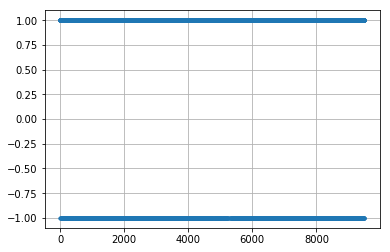

In [47]:
plt.plot(rewards_list,'.')
ax=plt.gca()
ax.grid(True)

### *if we train our network with this reward, it learns nothing*
because the reward is most of the time zero. in this case the agent does not get feedback what is good or bad. most gradients become zero because we multiply by reward in the mentioned algo.

it looks like the environment just rewards us when the ball passes through our paddel(we score -1) or our opponent's paddle(we score +1).

now think about it:

our paddle moves up and down, hits the ball and the ball travels to the left side of the screen. the opponent fails to catch it and we win and get a score of 1. 

in this scenario, which actions were actually good? 

* the action we took when we hit the ball? 
* the action we took when we get score of 1?

of course the first option is correct. 
the second option is wrong, because when the ball is reaching the opponent, our action does not matter. only the action that we took to hit the ball were important to winning. and everything after hitting the ball was irrelevant to our win. 

(a rather similar argument can be discussed about losing, the actions near when we got score of -1 is more important than actions taken many steps earlier)

**so here is the trick.**

we set the reward of actions taken before each reward, similar to the reward obtained.

for example if we got reward +1 at time 200, we say that reward of time 199 is +0.99, reward of time 198 is +0.98 and so on. 

with this reward definition, we have the rewards for actions that actually resulted in a +1 or -1. and we assume the more recent the action to the reward gained, the more important it is.

we define a function below, that does this for us. 

note that this may not be applicable in other environments, but serves our purposes for this project

In [48]:
# def process_rewards(r_list):
#     reward_decay=0.99
#     tmp_r=0
#     rew=np.zeros_like(r_list,dtype=np.float32)
#     for i in range(len(r_list)-1,-1,-1):
#         if r_list[i]==0:
#             tmp_r=tmp_r*reward_decay
#             rew[i]=tmp_r
#         else: 
#             tmp_r = r_list[i]
#             rew[i]=tmp_r
#     return rew

In [49]:
# # lets see what this gives us:
# plt.plot(process_rewards(rewards_list),'-')
# ax=plt.gca()
# ax.grid(True)

you can see that in the above chart we got better distribution for rewards. reward is -1 where it was -1 and now steps before it has some value near -1 (for example -0.9) and similar process happens for positive rewards. 

further more we refine the function to subtract rewards by mean and divide by std, and then discuss the results.

In [50]:
# def process_rewards(r_list):
#     reward_decay=0.99
#     tmp_r=0
#     rew=np.zeros_like(r_list,dtype=np.float32)
#     for i in range(len(r_list)-1,-1,-1):
#         if r_list[i]==0:
#             tmp_r=tmp_r*reward_decay
#             rew[i]=tmp_r
#         else: 
#             tmp_r = r_list[i]
#             rew[i]=tmp_r
#     rew -= np.mean(rew) # subtract by average
#     rew /= np.std(rew) # divide by std
#     return rew

note that we normalized the rewards, subtracting by mean and dividing by std. this may not be perfect but works for this project.(more discussion after the plot)

lets see our reformatted rewards: 

In [51]:
# plt.plot(process_rewards(rewards_list),'-',)
# ax=plt.gca()
# ax.grid(True)

so now we have non zero rewards most of the time. 

in points we got -1 reward, the new score is aout -1.5 as seen above and steps before it also have negative rewards. the negativity of the reward goes down as we go to the left from each -1.5 score. 

### some discussion about positive rewards in early steps of losing episodes:
also you can see that we got some positive scores in our new chart. this is because we subtracted by mean.
think about what it can result?

the positive reward happens in the long sequences of playing. these are situations where we catched the ball and didnt get a -1 immediately, but we lost later because we failed to catch the ball when it came toward us.

setting a negative score is logical because we ended up getting a -1. setting a positive score could be justified by that we approve actions where we catched the ball and did not get -1 reward immediately (maybe we didnt win either)

the above scoring method could prove a bit problematic when we are winning. it may discourage actions in early steps of a sequence which ends in winning. but we dont further consider discuss it here. 

so now that we have defined our rewards, we can go to next step and start training the network. 

# 6. Example of simluation and training

In [52]:
# first generate an episode:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [53]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 9500
shape of each state=(1, 500)
length of rewards= 9500


In [54]:
#preprocess inputs for training: 
    
x=np.array(states_list)

#episode_reward=np.expand_dims(process_rewards(rewards_list),1)
episode_reward=np.expand_dims(rewards_list,1)
y_tmp = np.array(up_or_down_action_list) # 1 if we chose up, 0 if down
y_true = np.expand_dims(y_tmp,1) # modify shape. this is neccassary for keras


print("episode_reward.shape =",episode_reward.shape)
print("x.shape =",x.shape)
print("y_true.shape =",y_true.shape)

episode_reward.shape = (9500, 1)
x.shape = (9500, 1, 500)
y_true.shape = (9500, 1)


In [55]:
# fit the model with inputs and outputs.
policy_network_train.fit(x=[x,episode_reward],y=y_true)

Epoch 1/1
9500/9500 [==============================] - 1s 58us/step - loss: 0.3966


# 7. Training the network

for the actual training, we generate some episode, then train on the batch. 
we can also log the rewards to keep records

In [56]:
# we define a helper function to create a batch of simulations
# and after the batch simulations, preprocess data and fit the network
def generate_episode_batches_and_train_network(n_batches=10):
    batch_state_list=[]
    batch_up_or_down_action_list=[]
    batch_rewards_list=[]
    batch_network_output_list=[]
    for i in range(n_batches):
        states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)   
        batch_state_list.extend(states_list[15:])
        batch_network_output_list.extend(network_output_list[15:])
        batch_up_or_down_action_list.extend(up_or_down_action_list[15:])
        batch_rewards_list.extend(rewards_list[15:])
    
    episode_reward=np.expand_dims(batch_rewards_list,1)
    x=np.array(batch_state_list)
    y_tmp = np.array(batch_up_or_down_action_list)
    y_true = np.expand_dims(y_tmp,1)
    policy_network_train.fit(x=[x,episode_reward],y=y_true)

    return batch_state_list,batch_up_or_down_action_list,batch_rewards_list,batch_network_output_list

In [57]:
# we define a helper function to create a batch of simulations
# and after the batch simulations, preprocess data and fit the network
# def generate_episode_batches_and_train_network(n_batches=10):
#     env = gym.make('Pong-v0')
#     batch_state_list=[]
#     batch_up_or_down_action_list=[]
#     batch_rewards_list=[]
#     batch_network_output_list=[]
#     for i in range(n_batches):
#         states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)   
#         batch_state_list.extend(states_list[15:])
#         batch_network_output_list.extend(network_output_list[15:])
#         batch_up_or_down_action_list.extend(up_or_down_action_list[15:])
#         batch_rewards_list.extend(rewards_list[15:])
    
#     episode_reward=np.expand_dims(process_rewards(batch_rewards_list),1)
#     x=np.array(batch_state_list)
#     y_tmp = np.array(batch_up_or_down_action_list)
#     y_true = np.expand_dims(y_tmp,1)
#     policy_network_train.fit(x=[x,episode_reward],y=y_true)

#     return batch_state_list,batch_up_or_down_action_list,batch_rewards_list,batch_network_output_list

we write a script to save the model in a file and log rewards from time to time.

In [58]:
train_n_times = 21 # for actual training, about 5000 may be a good start. 
for i in range(train_n_times):
    states_list,up_or_down_action_list,rewards_list,network_output_list=generate_episode_batches_and_train_network(10)
    if i%10==0:
        print("i="+str(i))
        rr=np.array(rewards_list)
        # i keep how many times we won in batch. you can use log more details more frequently
        print('count win='+str(len(rr[rr>0]))) 
        policy_network_model.save("policy_network_model_simple.h5")
        policy_network_model.save("policy_network_model_simple"+str(i)+".h5")
        with open('rews_model_simple.txt','a') as f_rew:
            f_rew.write("i="+str(i)+'       reward= '+str(len(rr[rr > 0])))
            f_rew.write("\n")
print("Training is completed")

Epoch 1/1
94850/94850 [==============================] - 4s 45us/step - loss: 0.4060
i=0
count win=75840
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3824
Epoch 1/1
94850/94850 [==============================] - 4s 45us/step - loss: 0.3548
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3706
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3641
Epoch 1/1
94850/94850 [==============================] - 4s 45us/step - loss: 0.3239
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3021
Epoch 1/1
94850/94850 [==============================] - 4s 47us/step - loss: 0.3365
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3468
Epoch 1/1
94850/94850 [==============================] - 4s 46us/step - loss: 0.3645
Epoch 1/1
94850/94850 [==============================] - 4s 45us/step - loss: 0.3727
i=10
count win=75840
Epoch 1/1
94850/94850 [=

i let it train for some batches here for presentation purposes. **in actual training we should let it run for much more episodes**.(about 1000 to 100000)

the model we defined earlier had 1.28 million params. so the process of simulation and training is kind of slow. u can try and simplify the model or maybe use convolutional models.

# 8. Playing the Trained Network

In [47]:
import time
def play_and_show_episode(policy_network):
    #env = gym.make('Pong-v0')
    done=False
    observation = env.reset()
    new_observation = observation
    while done==False:
        time.sleep(1/80)
        
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability])
        
        #env.render()
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        if reward!=0:
            print(reward)
        if done:
            break
        
    env.close()

if you have trained the network for some amount of time, you can see that the agent has learned some tricks to defend and even win.

note that the default model with 1.2 million params we defined earlier may take a huge amount of training to learn to win sometimes.

# 9. Loading model from file

In [49]:
policy_network_model=keras.models.load_model("trained_simple_model_3300.h5")
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


since keras does not save the custom loss in the file we should redefine loss function and training model.

note that this is not needed if you dont want to continue the training of the saved model.

In [50]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')

def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken
        # loss = reward*(-actual*np.log(y_pred)-(1-actual)*np.log(1-y_pred)))
        
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred) # we could also do gradient clipping
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # put reward in effect
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        
        return policy_loss
    return loss

policy_network_train = keras.models.Model(inputs=[policy_network_model.input,episode_reward],outputs=policy_network_model.output)
my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

In [56]:
play_and_show_episode(policy_network_model)

NameError: name 'base' is not defined

# 10. Using Convolutional Model

In [52]:
policy_network_model=keras.models.load_model("trained_conv_model.h5")
policy_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 10)        4000      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 20)          20000     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 40)          7200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 160       
Total para

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [53]:
play_and_show_episode(policy_network_model)

NameError: name 'base' is not defined

In [54]:
%%HTML
<video width="320" height="420" controls>
  <source src="trained_convolutional_network.mp4" type="video/mp4">
</video>

# 11. Ideas & Thoughts


as you can see, both simple and convolutional models have learned to play and score some points.

our simple network takes more time for each simulation and training. the convolutional model takes less amount of time both for simulation and playing. probably because it has less parameters.

I played around a bit with convolutional models. the problem with them was that they get stuck in the bottom or top of the game, and it is hard for them to learn to get out of that situation. 

I didn't want to make perfect agents, but if you want, you can try and train the networks a lot more so they can play better.

I had access to high performance computing system of my university which has about 30 cores of cpu. The training on my own pc was much faster because of the clock of cpu (the cluster just has many weak cpus), but used the university cluster since it could train day and night. It took the simple network took about 3 days to run 1550 batches of 10 game simulations on the cluster.

Here are some ideas to improve the training and agents:

* **generate simulations of batches in parallel**. I tried using multithreading to generate and play batches of games at the same time to increase the speed of data generation. the problem was that the backend library for the game had issues creating environments in multiple threads. maybe you can overcome this by implementing a multiprocess method. 

* The convolutional models I used were very fast at generating actions and also training. Their problem was that after some training, they learned some tricks fast but took a lot of time for them to learn something new. The agent just stuck in the up or bottom of game screen and didnt try new things to score and learn. I think **using an epsilon-greedy policy** can improve the exploration of the networks.which means that each action has a minimum probablity of being chosen(for example 20%). Another idea could be **using off-policy method** which means another more explorative policy(for example a policy that just takes random actions) plays the game, and our target policy learns from the experience generated by the explorative policy.

* giving a reward to the agent for catching the ball could be good for not losing(for example a +0.5 reward). now we are just giving positive reward to agent for scoring. if it catched the ball and then got a -1 reward, it thinks it was probably bad that it catched the ball.  

* tuning the optimizer parameters may be helpful. I just modified learning rate a bit. 

**some thoughts about the agents' mind:**

We are far from general intelligence. The agent has no sense if there is a ball which moves around and hits and ricochets from walls and paddles. It has no notion of physics of the game. All it sees is that some neurons of the input fires and it take some actions. unlike a human, if he sees the ball moving in a new position and direction that it had not seen before, it cannot generalize from his past experience. It has no notion of the ball, environment, itself, reward and punishment and... the agent is just a regression model.this article might be interesting: https://medium.com/syncedreview/interview-with-dr-richard-sutton-we-might-have-strong-ai-algorithms-by-2030-a1052332d878

# 12. References and Suggested readings

great blog post by Andrej Karpathy: http://karpathy.github.io/2016/05/31/rl/
this project is actually re implementing the above blog post with some explanations on the coding and implementation. 

Richard Sutton has a great book: Reinforcement Learning: An Introduction. 
The book is kind of a bible for reinforcement learning. At the time of writing this, the draft of second version is available online. http://incompleteideas.net/book/the-book-2nd.html